In [1]:
from dataset import VocDataset
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
from config import opt

%matplotlib inline

In [2]:
device = 'cuda'
img_size = [416, 416]
class_num = 20
num_workers = 4
batch_size = 32

## load test data

In [3]:
VocTestDataLoader = DataLoader(VocDataset(is_train=False), batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers, drop_last=True)

testDataset = VocDataset(is_train=False)

## build net

In [4]:
from yolonet import Backbone

yolov2 = Backbone().to(device)

## load checkpoint

In [5]:
ckpt_path = './model_best_SGD.pkl'
state_dict = torch.load(ckpt_path)
model_weights = state_dict['model']
yolov2.load_state_dict(model_weights)

<All keys matched successfully>

## load anchors

In [6]:
from anchor_utils import parse_anchors
anchors = torch.from_numpy(parse_anchors(opt.anchors_path)).to(device)

print(anchors)

tensor([[ 42.3072,  55.4064],
        [102.1680, 128.3021],
        [161.7878, 259.1654],
        [303.0758, 154.8970],
        [359.5648, 320.2272]], device='cuda:0')


### bbox_iou

In [7]:
from box_utils import xywh2xyxy

def bbox_iou(bbox1, bbox2):
    """
    :param bbox1:
        [13, 13, 5, 4] / [x, y, w, h];
    :param bbox2:
        [13, 13, 5, 4] / [x, y, w, h];
    :return:
        [13, 13, 5];
    """
    # assert bbox1.shape == bbox2.shape
    bbox2 = xywh2xyxy(bbox2)
    bbox1 = xywh2xyxy(bbox1)
    # [13, 13, 5, 2] -> [13, 13, 5]
    bbox1_area = torch.prod(bbox1[..., [0, 1]] - bbox1[..., [2, 3]], dim=-1)
    bbox2_area = torch.prod(bbox2[..., [0, 1]] - bbox2[..., [2, 3]], dim=-1)

    # [13, 13, 5] & [13, 13, 5] -> [13, 13, 5]
    intersection_xmin = torch.max(bbox1[..., 0], bbox2[..., 0])
    intersection_ymin = torch.max(bbox1[..., 1], bbox2[..., 1])
    intersection_xmax = torch.min(bbox1[..., 2], bbox2[..., 2])
    intersection_ymax = torch.min(bbox1[..., 3], bbox2[..., 3])
    # [13, 13, 5] & [13, 13, 5] -> [13, 13, 5]
    intersection_w = torch.max(intersection_xmax - intersection_xmin, torch.tensor(0., device=device))
    intersection_h = torch.max(intersection_ymax - intersection_ymin, torch.tensor(0., device=device))
    intersection_area = intersection_w * intersection_h
    # [13, 13, 5] & ([13, 13, 5] & [13, 13, 5] & [13, 13, 5]) -> [13, 13, 5]
    ious = intersection_area / (bbox1_area + bbox2_area - intersection_area + 1e-10)
    # ious shape: [13, 13, 5]
    return ious

### reorg_layer

In [8]:
def reorg_layer(preds, anchors=anchors):
    """
    :param preds:
        [N, 13, 13, 125]
    :param anchors:
        [[w, h], ,,,]
        注意：kmeans得到anchors的w,h是相对于输入图片的scale的(也就是416)，论文中的p_w,p_h是相对于feature map大小的，
        计算loss时需要先将anchor的scale转换到feature map的scale
    :return:
        bboxes: [batch_size, 13, 13, 5, 4]
        confs_logit: [batch_size, 13, 13, 5, 1]
        classes_logit: [batch_size, 13, 13, 5, 20]
    """
    # grid_size format is [h,w]
    grid_size = [preds.size(1), preds.size(2)]

    # ratio: feature map与输入图片的缩放比
    # ratio format is [h,w]
    ratio = torch.tensor([img_size[0], img_size[1]], dtype=torch.float32) / torch.tensor(grid_size, dtype=torch.float32)
    ratio = ratio.to(device)
    # rescaled_anchors format is [w,h] / make anchors's scale same as predicts
    rescaled_anchors = (anchors / ratio.flip(0)).to(device)
    # resahpe preds to [N, 13, 13, 5, 25]
    preds = preds.reshape(-1, grid_size[0], grid_size[1], opt.B, preds.size(-1) // opt.B)

    # box_xy: [N, 13, 13, 5, 2] / format [x, y]
    # box_wh: [N, 13, 13, 5, 2] / format [w, h]
    # confs: [N, 13, 13, 5, 1]
    # classes: [N, 13, 13, 5, 20]
    box_xy, box_wh, confs_logit, classes_logit = torch.split(preds, [2, 2, 1, class_num], dim=-1)
    box_xy = torch.sigmoid(box_xy)
    grid_x = np.arange(grid_size[1], dtype=np.float32)
    grid_y = np.arange(grid_size[0], dtype=np.float32)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)

    xy_offset = np.concatenate([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)], axis=-1)
    # xy_offset: [13, 13, 1, 2]
    xy_offset = torch.from_numpy(xy_offset).to(torch.float32).to(device)
    xy_offset = xy_offset.contiguous().view(grid_size[1], grid_size[0], 1, 2)

    # rescale to input_image scale
    box_xy = (box_xy + xy_offset) * ratio.flip(0)
    # rescale to input_image scale
    box_wh = torch.exp(box_wh) * rescaled_anchors
    # avoid getting Nan
    box_wh = torch.clamp_min(box_wh, 1e-7)
    box_wh = box_wh * ratio.flip(0)

    # reset scaled pred_box to bounding box format [x, y, w, h]
    # bboxes: [N, 13, 13, 5, 4]
    bboxes = torch.cat([box_xy, box_wh], dim=-1)

    return xy_offset, bboxes, confs_logit, classes_logit

In [9]:
from nms_utils import gpu_nms

def predict(preds):
    xy_offset, bboxes, confs_logit, classes_logit = reorg_layer(preds)
    grid_size = [xy_offset.shape[0], xy_offset.shape[1]]

    boxes = bboxes.reshape(-1, grid_size[0] * grid_size[1] * opt.B, 4)
    confs = confs_logit.reshape(-1, grid_size[0] * grid_size[1] * opt.B, 1)
    probs = classes_logit.reshape(-1, grid_size[0] * grid_size[1] * opt.B, opt.class_num)

    confs = confs.sigmoid()  # confs: [N, 13*13*5, 1]
    probs = torch.softmax(probs, dim=-1)  # probs: [N, 13*13*5, 20]

    xmin = boxes[..., [0]] - boxes[..., [2]] / 2
    ymin = boxes[..., [1]] - boxes[..., [3]] / 2
    xmax = boxes[..., [0]] + boxes[..., [2]] / 2
    ymax = boxes[..., [1]] + boxes[..., [3]] / 2
    # [N, 13*13*5, 4] / [xmin, ymin, xmax, ymax]
    boxes = torch.cat([xmin, ymin, xmax, ymax], dim=-1)
    return boxes, confs, probs

def nms(boxes, scores, score_threshold, iou_threshold, max_box_num):
    """
    :param boxes: [13*13*5, 4]
    :param scores: [13*13*5, 20]
    :param score_threshold:
    :param iou_threshold:
    :param max_box_num:
    :return:
     boxes_output shape: [X, 4]
     scores_output shape: [X,]
     labels_output shape: [X,]
    """
    assert boxes.dim() == 2 and scores.dim() == 2
    boxes = boxes.clamp(0., opt.img_size)
    boxes_output = []
    scores_output = []
    labels_output = []
    # [13*13*5, 20]
    score_mask = scores.ge(score_threshold)
    # do nms for each class
    for k in range(opt.class_num):
        valid_mask = score_mask[:, k]  # [M, 20]
        if valid_mask.sum() == 0:
            continue
        else:
            valid_boxes = boxes[valid_mask]  # [M, 4]
            valid_scores = scores[:, k][valid_mask]  # [M, 1]
            keep_index = gpu_nms(valid_boxes, valid_scores, iou_threshold)
            boxes_output.append(valid_boxes[keep_index])
            scores_output.extend(valid_scores[keep_index])
            labels_output.extend([k for _ in range(len(keep_index))])

    num_out = len(boxes_output)
    if num_out == 0:
        return torch.tensor([], device=opt.device), torch.tensor([], device=opt.device), torch.tensor([], device=opt.device)
    else:
        boxes_output = torch.cat(boxes_output, dim=0)
        scores_output = torch.tensor(scores_output)
        labels_output = torch.tensor(labels_output)
        if num_out > max_box_num:
            descend_order_index = torch.argsort(scores_output)[::-1]
            output_index = descend_order_index[:max_box_num]
        else:
            output_index = torch.arange(num_out)
        return boxes_output[output_index], scores_output[output_index], labels_output[output_index]


## eval

In [10]:
from nms_utils import nms
from plot_utils import plot_one
from torchvision import transforms

score_threshold = 0.3 
iou_threshold = 0.5
max_boxes_num = 100
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]
normailze = transforms.Compose([transforms.ToTensor(), transforms.Normalize(opt.mean, opt.std)])

def eval(yolov2, test_imgs, testDataset=testDataset):
    yolov2.eval()
    conf_list = []
    cls_list = []
    score_list = []
    steps = 0
    
    with torch.no_grad():
        for img_id in test_imgs:
            steps += 1
            resized_img, true_box, true_label = testDataset[img_id]
            img = normailze(resized_img)
#             img = torch.tensor(resized_img, dtype=torch.float32).permute(2, 0, 1)
            print(img.max(), img.min(), img.mean())
            # [3, 416, 416] -> [1, 3, 416, 416]
            img = torch.unsqueeze(img, dim=0)
            img = img.to(device)
            preds = yolov2(img)
            boxes, confs, probs = predict(preds)

            boxes = boxes.squeeze(0)  # [13*13*5, 4]
            confs = confs.squeeze(0)  # [13*13*5, 1]
            probs = probs.squeeze(0)  # [13*13*5, 20]
            scores = (confs * probs).squeeze(0)  # [13*13*5, 20]
            conf_list.extend(confs.detach().cpu().numpy())
            cls_list.extend(probs.detach().cpu().numpy())
            score_list.extend(scores.detach().cpu().numpy())
            pred_dict = {'conf': conf_list[-1].flatten(), 'cls': cls_list[-1].flatten(), 'score': score_list[-1].flatten()}
        
            # box_out: [xmin, ymin, xmax, ymax]
            # nms(boxes, scores, score_threshold, iou_threshold, max_box_num, device, class_num, img_size)
            box_out, score_out, label_out = nms(boxes, scores, 0.3, 0.5, 100, device=device, class_num=20, img_size=416)

            plot_dict = {'img': resized_img,
                         'pred_box': box_out.cpu().numpy(),
                         'pred_score': score_out.cpu().numpy(),
                         'pred_label': label_out.cpu().numpy(),
                         'gt_box': true_box,
                         'gt_label': true_label,
                         'img_name': img_id,
                         'save_path': './'}

            plot_one(plot_dict)

    msg = f"\n" \
          f"Score Mean: {np.mean(score_list):.5f} \n" \
          f"Score Max: {np.max(score_list):.5f} \n" \
          f"Score Min: {np.min(score_list):.5f} \n" \
          f"Max conf: {np.max(conf_list)} \n" \
          f"Max cls: {np.max(cls_list)}"
    print(msg)

[559, 305, 7, 623, 347, 769, 546, 960, 982, 172]
tensor(2.6226) tensor(-2.0837) tensor(0.4530)


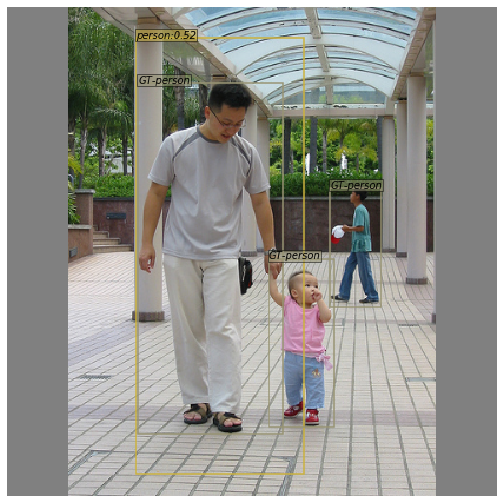

tensor(2.5529) tensor(-2.1008) tensor(-0.0337)


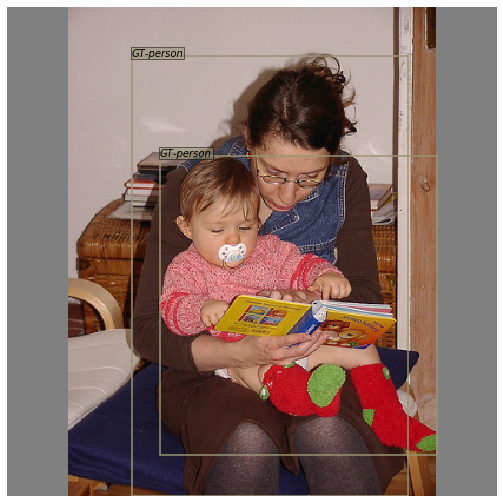

tensor(2.6400) tensor(-2.0323) tensor(0.2898)


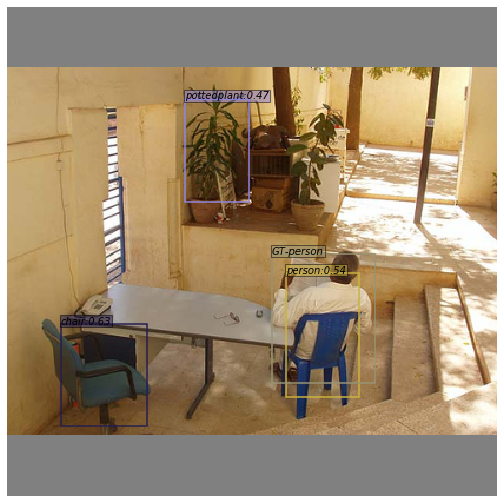

tensor(2.6400) tensor(-2.1179) tensor(-0.7440)


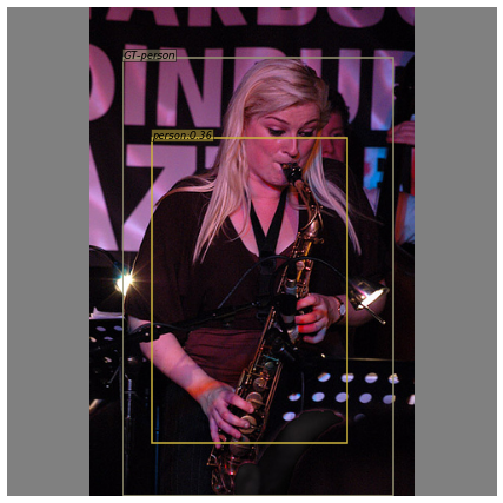

tensor(2.6400) tensor(-2.1179) tensor(-0.0706)


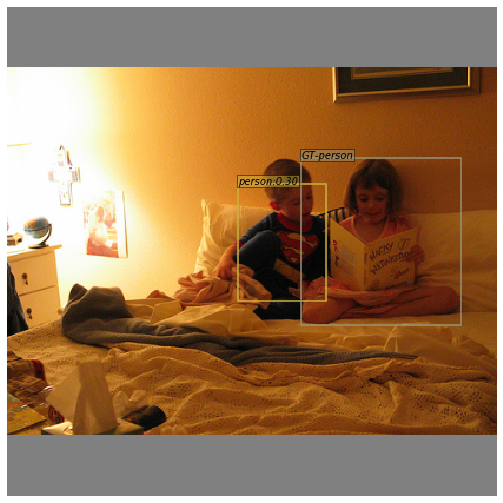

tensor(2.5877) tensor(-2.1179) tensor(-0.5133)


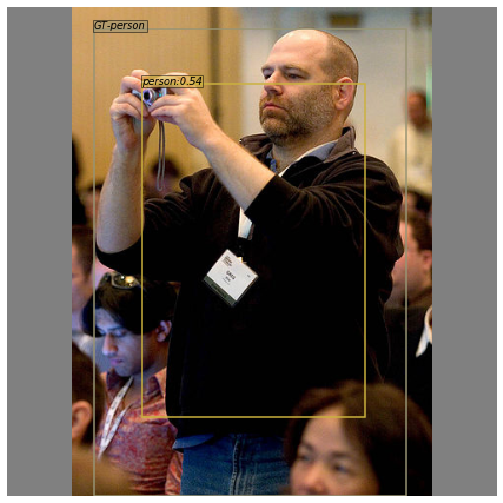

tensor(2.6400) tensor(-2.1179) tensor(0.0344)


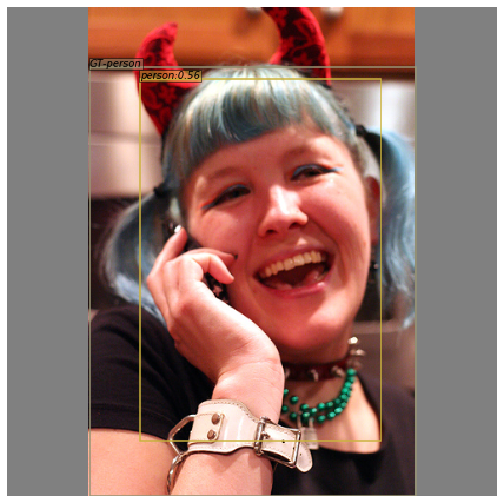

tensor(2.5703) tensor(-2.1179) tensor(0.0755)


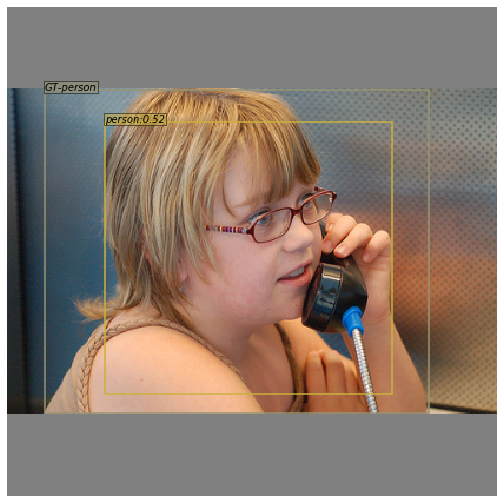

tensor(2.6400) tensor(-1.1247) tensor(-0.1523)


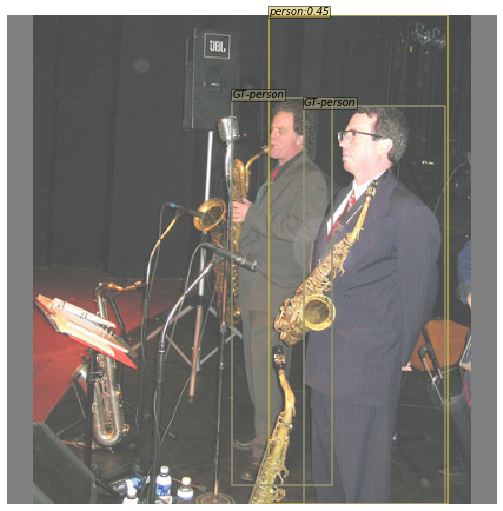

tensor(2.6400) tensor(-2.1179) tensor(-0.8520)


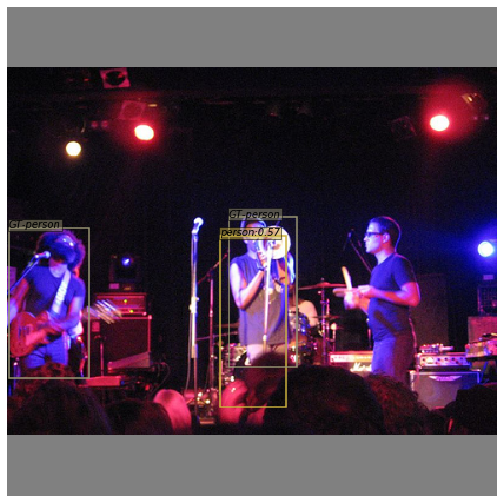


Score Mean: 0.00022 
Score Max: 0.63374 
Score Min: 0.00000 
Max conf: 0.6489330530166626 
Max cls: 0.9998892545700073


In [11]:
import random
test_imgs = [random.randint(0, 1000) for _ in range(10)]
print(test_imgs)
eval(yolov2, test_imgs)